In [1]:
from PIL import Image
import jittor as jt
from omegaconf import OmegaConf
from model_jittor.autoencoder.vqgan import VQModelInference
import albumentations as A
import cv2
from utils import *

%load_ext autoreload
%autoreload 2

[i 0714 10:33:12.113786 16 log.cc:351] Load log_sync: 1
[i 0714 10:33:12.176500 16 compiler.py:955] Jittor(1.3.4.16) src: /root/miniconda3/lib/python3.7/site-packages/jittor
[i 0714 10:33:12.190369 16 compiler.py:956] g++ at /usr/bin/g++(7.5.0)
[i 0714 10:33:12.192376 16 compiler.py:957] cache_path: /root/.cache/jittor/jt1.3.4/g++7.5.0/py3.7.13/Linux-4.4.0-11x36/IntelRXeonRGolx8d/default
[i 0714 10:33:12.207296 16 __init__.py:411] Found /usr/local/cuda/bin/nvcc(11.2.152) at /usr/local/cuda/bin/nvcc.
[i 0714 10:33:12.222044 16 __init__.py:411] Found addr2line(2.30) at /usr/bin/addr2line.
[i 0714 10:33:12.503747 16 compiler.py:1010] cuda key:cu11.2.152_sm_86
[i 0714 10:33:12.698147 16 __init__.py:227] Total mem: 376.52GB, using 16 procs for compiling.
[i 0714 10:33:12.889025 16 jit_compiler.cc:28] Load cc_path: /usr/bin/g++
[i 0714 10:33:13.406640 16 init.cc:62] Found cuda archs: [86,]
/root/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please 

In [2]:
config = OmegaConf.load('./configs/vqgan.yaml')
model = VQModelInference(**config.model)

Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
Loaded VQModel's ckeckpoint from '/nas/wang/champ/save/run-20220712_113903-23ga69ye/checkpoints/epoch_60.ckpt'


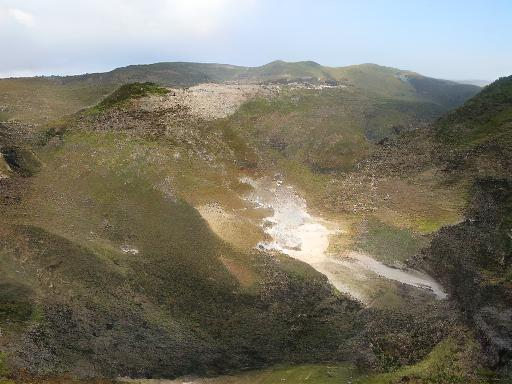

In [3]:
Image.open('./results/4096_finetuen_epoch5_without_quantize_bs10_step200/10026730584_85d86c1c64_b.jpg')

In [4]:
img = cv2.imread('./results/4096_finetuen_epoch5_without_quantize_bs10_step200/10026730584_85d86c1c64_b.jpg')
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [5]:
train_transform = A.Compose([ 
    A.SmallestMaxSize(max_size=384),
    A.Lambda(image=convert_to_negetive_one_positive_one),
    ToVar(),
])

In [6]:
image = train_transform(image=image)['image'][None, Ellipsis]
print(image.shape)

[1,3,384,512,]


In [7]:
z = model.encode(image)
print(z.shape)

[1,3,96,128,]


In [16]:
z.data.shape

(1, 3, 96, 128)

In [18]:
ii = z.data
blur = cv2.GaussianBlur(ii[0].transpose(1, 2, 0),(3,3),0)

In [20]:
blur.shape

(96, 128, 3)

In [21]:
x_hat = model.decode(jt.Var(blur.transpose(2, 0, 1))[None, Ellipsis])
print(x_hat.shape)

[1,3,384,512,]


In [22]:
x = (x_hat + 1) / 2
x = jt.clamp(x, 0, 1).data
x = x[0].transpose(1, 2, 0)
print(x.shape, type(x))

(384, 512, 3) <class 'numpy.ndarray'>


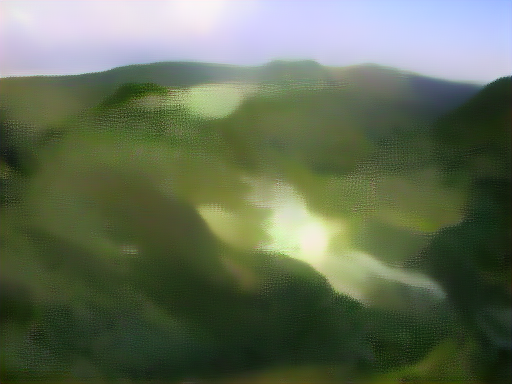

In [23]:
from jittor import transform
transform.to_pil_image(x)